Once we have done generic cell annotation, we will recluster T cells to identify specific cell types. 

In [1]:
#import needed packages
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy.external as sce
import warnings
#import scvi
import h5py
import anndata as ad
import decoupler as dc
import singler

In [56]:
#load tcell data.
data_path = '../t_cell_analysis/t_cell_data.h5ad'

# Read the HDF5 file into a DataFrame
t_cell_data = ad.read_h5ad(data_path)
t_cell_data

AnnData object with n_obs × n_vars = 27463 × 17278
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch', 'Condition', 'louvain', 'Cell_type_generic', 'Cell_type_generic_2'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'n_cells-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'n_cells-5', 'n_cells_by_counts-5', 'mean_counts-5', 'pct_dropout_by_counts-5', 'total_counts-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Cell_type_gen

In [33]:
sc.tl.pca(t_cell_data)
sc.external.pp.harmony_integrate(t_cell_data, key="batch")
sc.pp.neighbors(t_cell_data,use_rep="X_pca_harmony", n_neighbors=30)
sc.tl.louvain(t_cell_data)
sc.tl.umap(t_cell_data)

computing PCA
    with n_comps=50
    finished (0:00:03)


2024-11-25 16:56:07,881 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-11-25 16:56:12,514 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-11-25 16:56:12,578 - harmonypy - INFO - Iteration 1 of 10
2024-11-25 16:56:15,514 - harmonypy - INFO - Iteration 2 of 10
2024-11-25 16:56:18,468 - harmonypy - INFO - Iteration 3 of 10
2024-11-25 16:56:21,398 - harmonypy - INFO - Iteration 4 of 10
2024-11-25 16:56:23,871 - harmonypy - INFO - Converged after 4 iterations


computing neighbors
    finished (0:00:05)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:04)
computing UMAP
    finished (0:00:14)


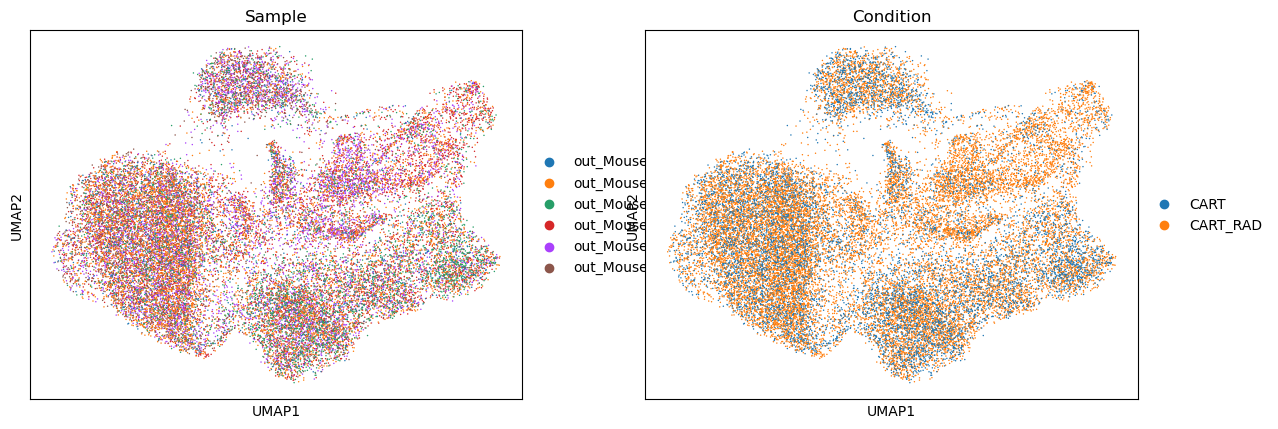

In [36]:
sc.pl.umap(
    t_cell_data,
    color=["Sample", "Condition"],
    ncols=2
)

Helper T cells (CD4+ T cells):
CD4 (Cluster of Differentiation 4): This marker is present on helper T cells and is involved in recognizing antigens presented by MHC class II molecules.
CXCR4 (C-X-C chemokine receptor type 4): Involved in migration and homing of T cells.
CCR5 (C-C chemokine receptor type 5): Another chemokine receptor involved in T cell migration.
CD25 (Interleukin-2 receptor alpha chain): Present on activated T cells.
Cytotoxic T cells (CD8+ T cells):
CD8 (Cluster of Differentiation 8): This marker is found on cytotoxic T cells and is involved in recognizing antigens presented by MHC class I molecules.
CD45RA (Leukocyte common antigen isoform RA): A marker for naive T cells.
CD45RO (Leukocyte common antigen isoform RO): A marker for memory T cells.
CD57 (Cluster of Differentiation 57): A marker for terminally differentiated effector T cells.
Regulatory T cells (Tregs):
FoxP3 (Forkhead box protein P3): A transcription factor that is a master regulator of Treg development and function.
CD25 (Interleukin-2 receptor alpha chain): Present on activated Tregs.
CTLA-4 (Cytotoxic T-lymphocyte-associated protein 4): A checkpoint molecule involved in Treg function.


Exhausted T cells, also known as dysfunctional T cells, are a subset of T cells that have become unresponsive or dysfunctional due to chronic antigen exposure, such as during chronic infections or cancer. These cells often express specific markers associated with exhaustion and exhibit reduced effector function. Some of the common markers used to identify exhausted T cells include:

PD-1 (Programmed cell death protein 1):
PD-1 is a cell surface receptor that is upregulated on exhausted T cells. Engagement of PD-1 with its ligands (PD-L1 and PD-L2) leads to inhibition of T cell activation and effector function.
LAG-3 (Lymphocyte-activation gene 3):
LAG-3 is another inhibitory receptor expressed on exhausted T cells. It regulates T cell function by inhibiting T cell proliferation and cytokine production.
Tim-3 (T cell immunoglobulin and mucin domain-containing protein 3):
Tim-3 is a marker of T cell exhaustion that is often co-expressed with PD-1. Engagement of Tim-3 with its ligands leads to T cell dysfunction and apoptosis.
TIGIT (T cell immunoreceptor with Ig and ITIM domains):
TIGIT is an inhibitory receptor that is upregulated on exhausted T cells. It regulates T cell activation and function by interacting with its ligands (CD155 and CD112).
2B4 (CD244):
2B4 is a co-stimulatory receptor that can also function as an inhibitory receptor on exhausted T cells. It regulates T cell activation and effector function.

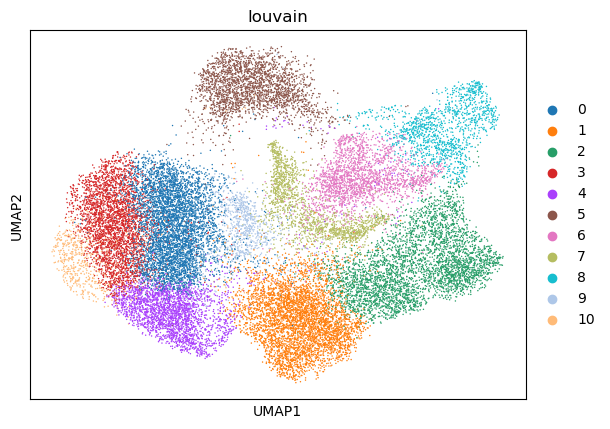

In [37]:
tcell_markers =['Cd3g', 'Trbc1', 'Cd2', 'Cd4', 'Cd8a', 'Cd8b1', 'Cxcr4', 'Ccr5', 'Foxp3', 'Tigit', "Il2ra", "Ikzf2"]
memory_markers= ['Ccr7', 'Sell', 'Klf2', 'Tcf7', 'Il7r', 'Cd27', 'Lef1']
inhibitory_markers=['Ctla4', 'Lag3', 'Tox']
cytotoxic_markers=['Gzmb', 'Gzmk', 'Klrk1', 'Prf1', 'Nkg7']
effector_markers=['Cd44', 'Id2', 'Klrg1', 'Ifng', 'Gzmb']
terminaly_exhausted=['Lag3', 'Tigit', 'Havcr2', 'Tox', 'Gzmb', 'Prf1' ]
migartion_adhesion_markers=['S1pr1', 'Klf2', 'Itgb1', 'Cd44', 'Ly6c2']

sc.pl.umap(
    t_cell_data,
    color="louvain", 
)


In [72]:
sc.settings.verbosity = 2  # reduce the verbosity
sc.tl.rank_genes_groups(t_cell_data, 'louvain', method='wilcoxon')

ranking genes
    finished (0:00:21)


In [73]:
marker_list_all=sc.get.rank_genes_groups_df(t_cell_data, group=None, key='rank_genes_groups', pval_cutoff=0.1)
marker_list_all.to_csv('tcell_markers.csv', index=False)

In [74]:
top_markers=pd.DataFrame(t_cell_data.uns['rank_genes_groups']['names']).head(5)
# Initialize an empty dictionary to store the marker genes for each cluster
marker = {}

# Iterate over the columns of the DataFrame
for cluster in top_markers.columns:
    # Convert the cluster to a string
    cluster_str = str(cluster)
    # Extract the genes for the current cluster
    genes = top_markers[cluster].dropna().tolist()
    # Add the genes for the current cluster to the dictionary
    marker[cluster_str] = genes

marker

{'0': ['Lef1', 'Igfbp4', 'Bcl2', 'Satb1', 'Bach2'],
 '1': ['Ikzf2', 'Il2ra', 'Ift80', 'Smc4', 'Rabgap1l'],
 '2': ['Ikzf2', 'Ctla4', 'Tox', 'Rabgap1l', 'Atxn1'],
 '3': ['Stt3b', 'Bach2', 'Kif1b', 'Lef1', 'Il7r'],
 '4': ['Rps16', 'Rpl13', 'Rps24', 'Rps8', 'Rps7'],
 '5': ['Cd8b1', 'Nkg7', 'Cd8a', 'Ly6c2', 'Runx3'],
 '6': ['Ifi27l2a', 'Lgals1', 'Actb', 'Actg1', 'Coro1a'],
 '7': ['Itgb1', 'Atxn1', 'Arhgap26', 'Slamf6', 'Cd28'],
 '8': ['Hmgb2', 'Pclaf', 'Stmn1', 'H2afz', 'Ptma'],
 '9': ['Sidt1', 'Mndal', 'Slfn1', 'Iigp1', 'Smchd1'],
 '10': ['Pifo', 'Gm42722', 'Rps16', 'Rps29', 'Tpt1']}

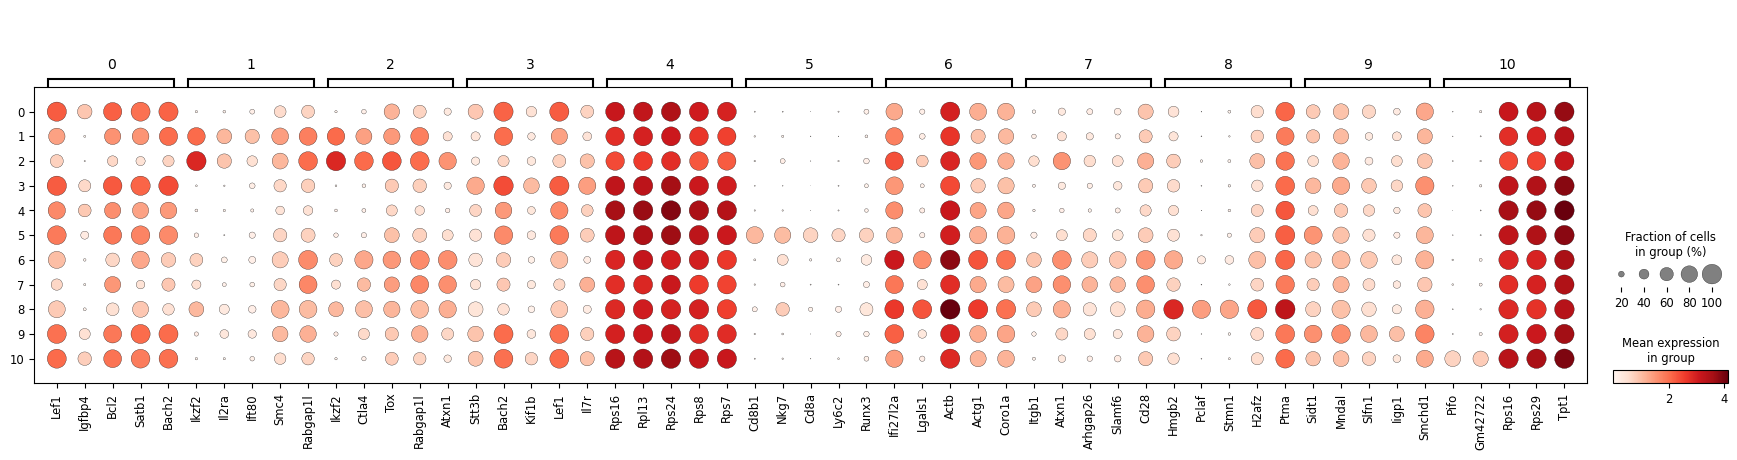

In [75]:
sc.pl.dotplot(t_cell_data, marker, 'louvain')


In [13]:
#based on known markers share by Rachel and Jonathan Villena-Vargas plus https://spica.unil.ch/refs/1?gene1=Iigp1&gene2=Slfn1 the annotation of cell types would be the next one:
t_cell_data.obs["T_cell_type_fine"]="Naive_1"
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '1', 'T_cell_type_fine'] = 'Tregs_1'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '2', 'T_cell_type_fine'] = 'Tregs_2'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '3', 'T_cell_type_fine'] = 'Naive_2'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '4', 'T_cell_type_fine'] = 'T_ribosomal'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '5', 'T_cell_type_fine'] = 'T_cd8'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '6', 'T_cell_type_fine'] = 'T_effector_cytotoxic_1'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '7', 'T_cell_type_fine'] = 'T_effector'
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '8', 'T_cell_type_fine'] = 'T_effector_cytotoxic_2'
#Type 1 T helper
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '9', 'T_cell_type_fine'] = 'Th1'
#T follicular T helper
t_cell_data.obs.loc[t_cell_data.obs['louvain'] == '10', 'T_cell_type_fine'] = 'Tfh'


In [43]:

# Create a new figure with the desired width and height
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust the width and height as needed

# Plot UMAP with color based on T_cell_type_fine on the specified axes
sc.pl.umap(
    t_cell_data,
    color=["T_cell_type_fine"],
    ax=ax,  # Pass the created axis
    show=False,  # Do not immediately show the plot
    legend_loc='on data'  # Disable the automatic legend
)

# Manually create a legend
handles, labels = ax.get_legend_handles_labels()
# Create a legend with unique labels only
unique_labels = dict(zip(labels, handles))
ax.legend(unique_labels.values(), unique_labels.keys(), loc='upper right')  # Adjust loc as needed

# Remove the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the modified figure
fig.savefig('T_cell_reclust_umap.png')
plt.close(fig)  # Close the figure to avoid display overlap



In [72]:
#two plots per conditon
for condition in t_cell_data.obs['Condition'].unique():
    # Subset the data for the current sample
    subset_data = t_cell_data[t_cell_data.obs['Condition'] == condition, :]
    # Plot UMAP with color based on batch
    fig=sc.pl.umap(subset_data, 
               color='T_cell_type_fine', 
               title=f'UMAP - {condition}', 
               size=8, 
               frameon=None, return_fig=True)
    # Access the axes
    ax = fig.axes[0]

    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

    # Save the figure for the current condition
    fig.savefig(f't_cell_{condition}_umap.pdf', bbox_inches='tight', format='pdf')

    # Close the figure to free memory
    plt.close(fig)

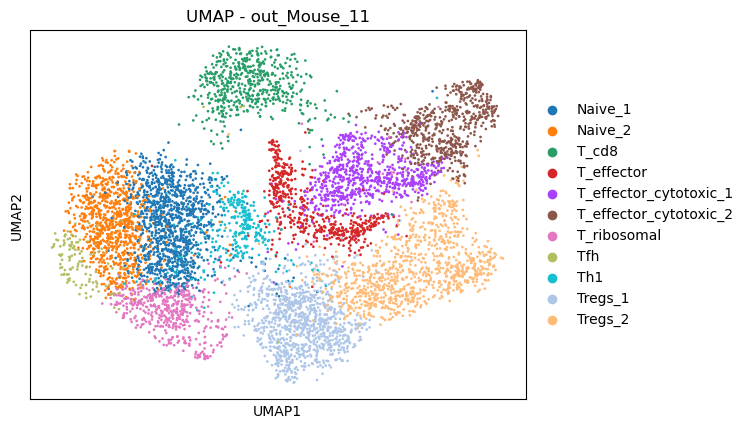

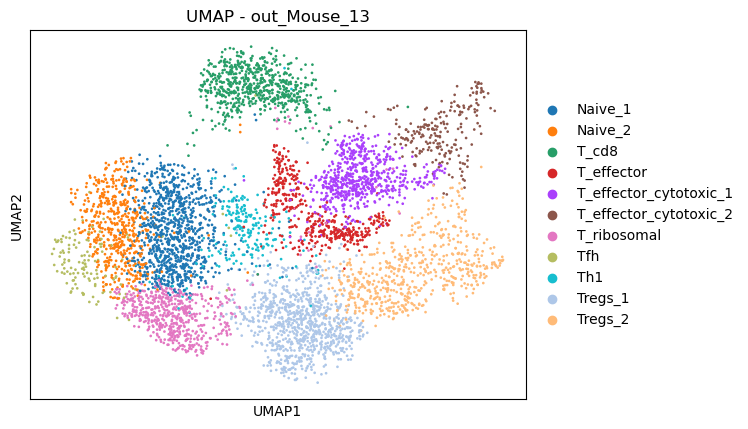

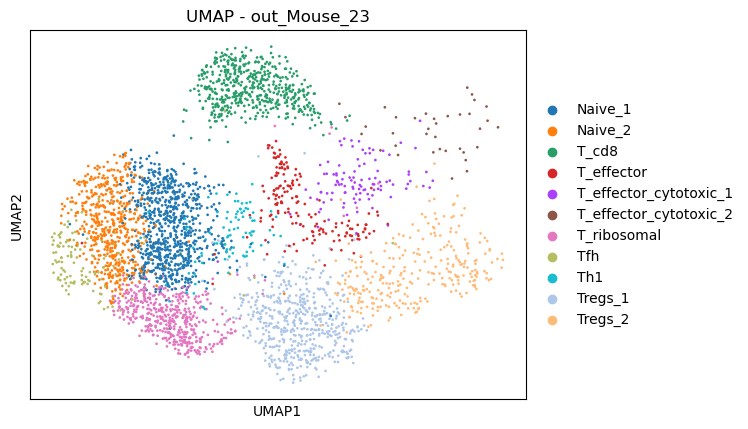

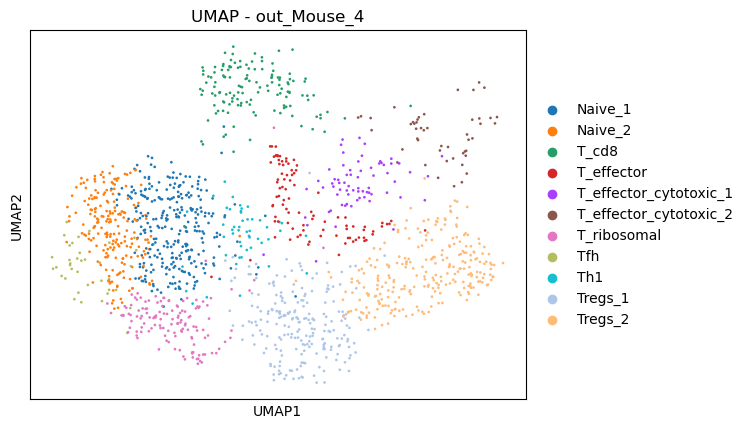

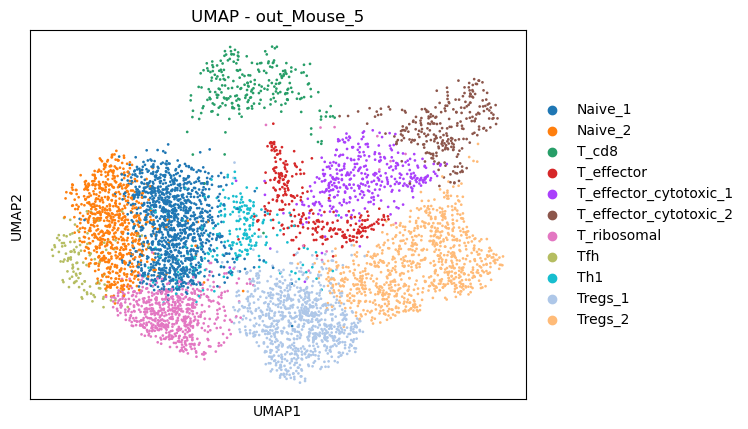

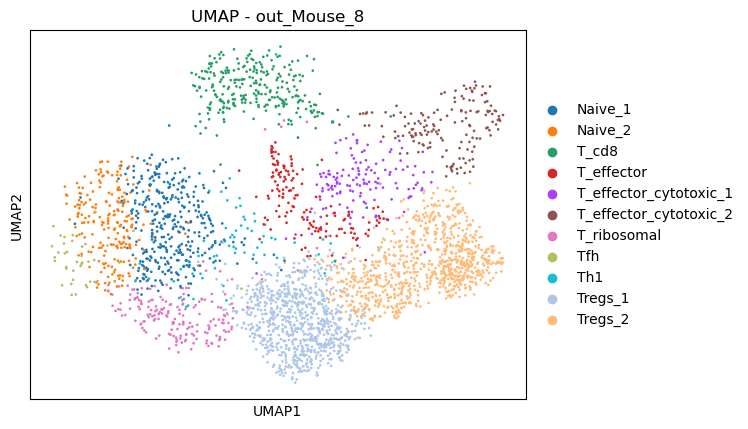

In [8]:



#two plots per conditon
for sample in t_cell_data.obs['Sample'].unique():
    # Subset the data for the current sample
    subset_data = t_cell_data[t_cell_data.obs['Sample'] == sample, :]
    # Plot UMAP with color based on batch
    sc.pl.umap(subset_data, color='T_cell_type_fine', title=f'UMAP - {sample}', size=15)

In [9]:
for Condition in t_cell_data.obs['Condition'].unique():
    condition_df = t_cell_data.obs[t_cell_data.obs['Condition']==Condition]
    print(f' Number of cells in {Condition} for each cell type is : {condition_df.T_cell_type_fine.value_counts()}' )

 Number of cells in CART_RAD for each cell type is : T_cell_type_fine
Naive_1                   3357
Tregs_1                   2712
Tregs_2                   2464
Naive_2                   2150
T_ribosomal               1729
T_effector_cytotoxic_1    1723
T_cd8                     1438
T_effector                1229
T_effector_cytotoxic_2    1085
Th1                        758
Tfh                        372
Name: count, dtype: int64
 Number of cells in CART for each cell type is : T_cell_type_fine
Tregs_1                   1551
Naive_1                   1441
Tregs_2                   1391
Naive_2                    970
T_cd8                      926
T_ribosomal                796
T_effector                 408
T_effector_cytotoxic_1     314
T_effector_cytotoxic_2     240
Th1                        207
Tfh                        202
Name: count, dtype: int64


In [10]:
sc.tl.rank_genes_groups(t_cell_data, groupby="T_cell_type_fine",  method='wilcoxon', key_added='T_cell_type_fine')


In [11]:
df_markers_harmony = sc.get.rank_genes_groups_df(adata=t_cell_data, group=None,key='T_cell_type_fine')


In [12]:
df_markers_harmony.to_csv('tcell_markers.csv', index=False)

In [13]:
top_markers=pd.DataFrame(t_cell_data.uns['T_cell_type_fine']['names']).head(5)

#plot top markers obtained by DE analysis between the different groups.
marker = {}

# Iterate over the columns of the DataFrame
for cluster in top_markers.columns:
    # Convert the cluster to a string
    cluster_str = str(cluster)
    # Extract the genes for the current cluster
    genes = top_markers[cluster].dropna().tolist()
    # Add the genes for the current cluster to the dictionary
    marker[cluster_str] = genes

marker

{'Naive_1': ['Lef1', 'Igfbp4', 'Bcl2', 'Satb1', 'Bach2'],
 'Naive_2': ['Stt3b', 'Bach2', 'Kif1b', 'Lef1', 'Il7r'],
 'T_cd8': ['Cd8b1', 'Nkg7', 'Cd8a', 'Ly6c2', 'Runx3'],
 'T_effector': ['Itgb1', 'Atxn1', 'Arhgap26', 'Slamf6', 'Cd28'],
 'T_effector_cytotoxic_1': ['Ifi27l2a', 'Lgals1', 'Actb', 'Actg1', 'Coro1a'],
 'T_effector_cytotoxic_2': ['Hmgb2', 'Pclaf', 'Stmn1', 'H2afz', 'Ptma'],
 'T_ribosomal': ['Rps16', 'Rpl13', 'Rps24', 'Rps8', 'Rps7'],
 'Tfh': ['Pifo', 'Gm42722', 'Rps16', 'Rps29', 'Tpt1'],
 'Th1': ['Sidt1', 'Mndal', 'Slfn1', 'Iigp1', 'Smchd1'],
 'Tregs_1': ['Ikzf2', 'Il2ra', 'Ift80', 'Smc4', 'Rabgap1l'],
 'Tregs_2': ['Ikzf2', 'Ctla4', 'Tox', 'Rabgap1l', 'Atxn1']}

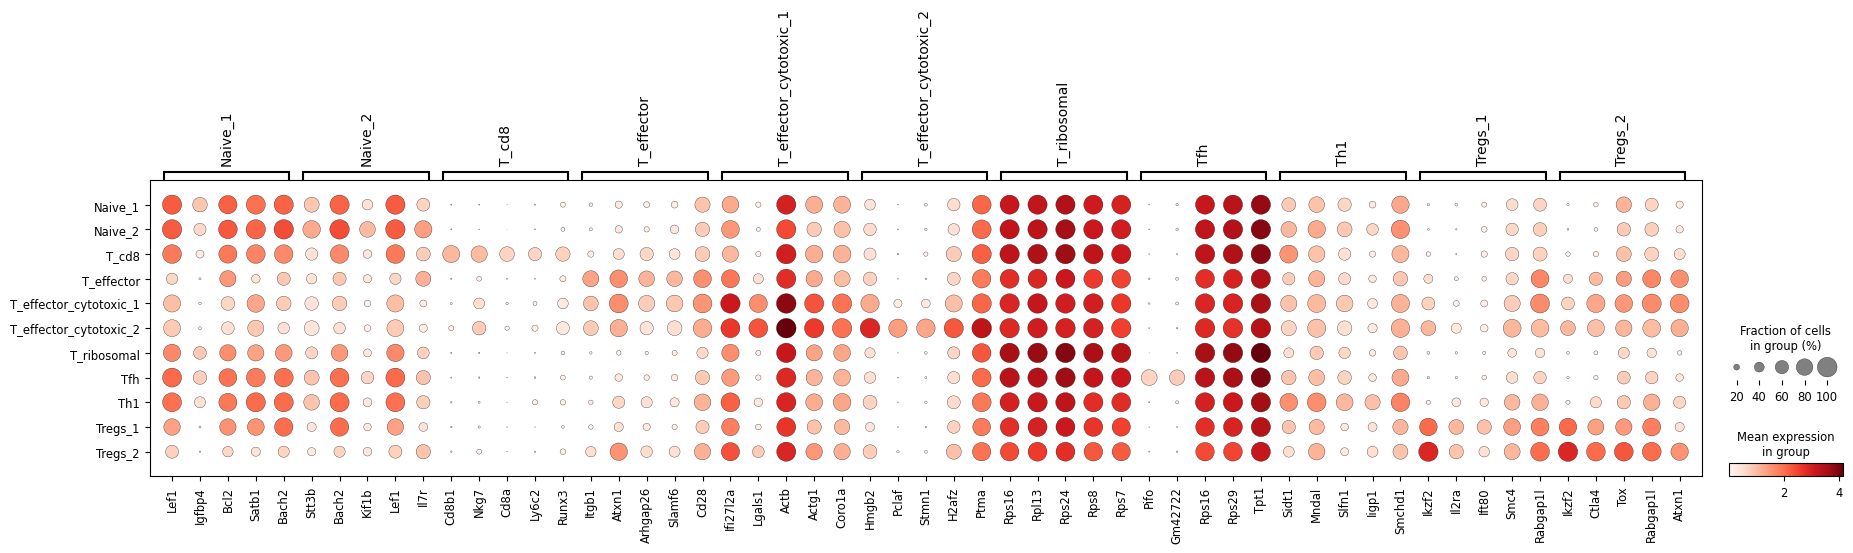

In [14]:
sc.pl.dotplot(t_cell_data, marker, groupby='T_cell_type_fine')

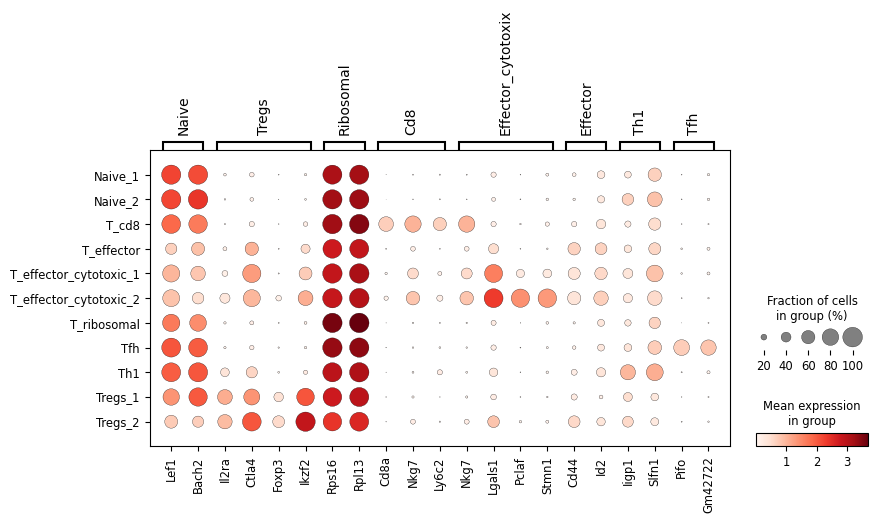

In [15]:
top_marker = {'Naive': ["Lef1","Bach2"], 'Tregs': ['Il2ra', 'Ctla4', 'Foxp3', "Ikzf2"], 'Ribosomal': ['Rps16' , 'Rpl13'], 'Cd8':['Cd8a', "Nkg7", "Ly6c2"],'Effector_cytotoxix':["Nkg7","Lgals1", "Pclaf","Stmn1"], "Effector": ["Cd44", "Id2"], 'Th1': ['Iigp1', 'Slfn1'], 'Tfh': ['Pifo', 'Gm42722']}

sc.pl.dotplot(t_cell_data, top_marker, groupby='T_cell_type_fine')

In [16]:
# save object
t_cell_re_clustered = 't_cell_data_reclustered.h5ad'
#t_cell_data.write(t_cell_re_clustered)

In [40]:
#load tcell data.
t_cell_re_clustered = '../t_cell_analysis/t_cell_data_reclustered.h5ad'

# Read the HDF5 file into a DataFrame
t_cell_data = ad.read_h5ad(t_cell_re_clustered)

In [41]:
#check malt1 and cd19 expression across cells
list_of_genes = ["Myc"]
gene_dataframe = pd.DataFrame()

for gene in list_of_genes:
    for condition in t_cell_data.obs["Condition"].unique():
        for clusters in t_cell_data.obs["louvain"].unique():
            #subset t cells to rerun clustering and annotation.
            subset_df = t_cell_data[t_cell_data.obs['louvain'].isin([clusters])]

            gene_object_table = subset_df[subset_df.obs['Condition'].isin([condition])]
        
            new_df=pd.DataFrame({'Expression':gene_object_table[:, gene].layers["counts"].todense().A1})
            new_df['Gene'] = gene
            new_df['Condition'] = condition
            new_df['Louvain_clus'] = clusters
            gene_dataframe = pd.concat([gene_dataframe, new_df], ignore_index=True)
print(gene_dataframe)

       Expression Gene Condition Louvain_clus
0             0.0  Myc  CART_RAD            1
1             0.0  Myc  CART_RAD            1
2             0.0  Myc  CART_RAD            1
3             0.0  Myc  CART_RAD            1
4             0.0  Myc  CART_RAD            1
...           ...  ...       ...          ...
27458         0.0  Myc      CART            7
27459         0.0  Myc      CART            7
27460         0.0  Myc      CART            7
27461         0.0  Myc      CART            7
27462         0.0  Myc      CART            7

[27463 rows x 4 columns]


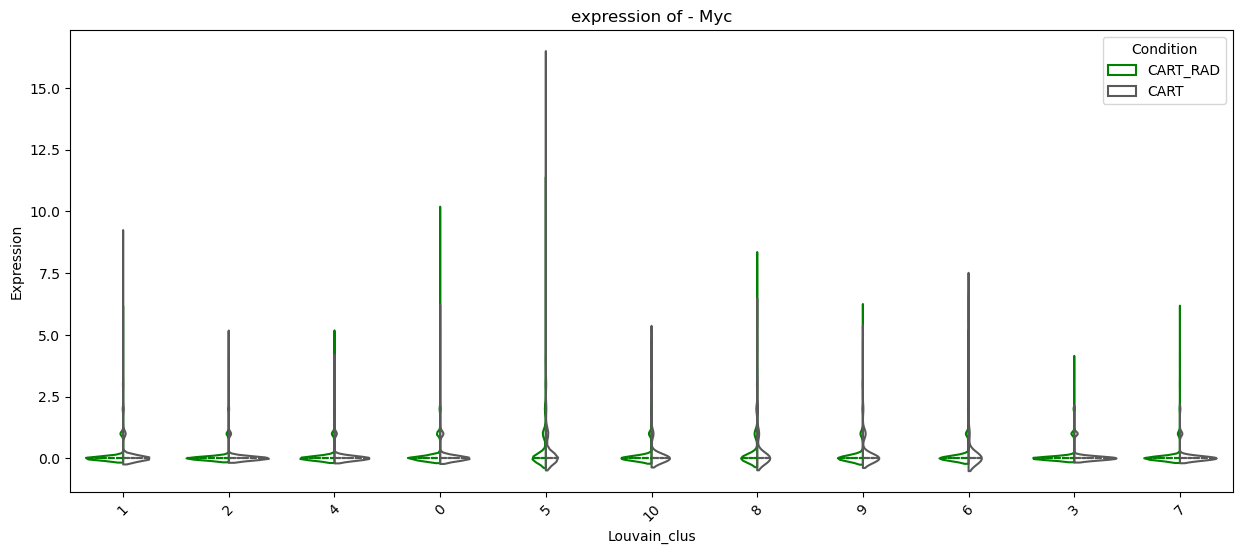

In [42]:
for gene in list_of_genes:
    # Subset the data for the current sample
    subset_data = gene_dataframe[gene_dataframe['Gene'] == gene]
    # Plot UMAP with color based on batch
    #print(subset_data)
    plt.figure(figsize=(15, 6))

    sns.violinplot(data=subset_data, x="Louvain_clus", y="Expression", hue="Condition",
               split=True, inner="quart",fill=False,
               palette={"CART_RAD": "g", "CART": ".35"})
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.title(f'expression of - {gene}')
    # Show the plot
    plt.show()

Idenitfy Myc expressing cells and run binomial analysis to check if enrichment in any of the conditions.

In [43]:
myc_expression=t_cell_data[:, 'Myc'].layers["counts"].todense().A1

In [44]:
cells_with_mycpos = t_cell_data.obs_names[np.where(myc_expression > 0)[0]]
# Subset AnnData object based on cells with 0 expression counts for the Mac gene
tcell_myc_cart = t_cell_data[cells_with_mycpos, :]
tcell_myc_cart

View of AnnData object with n_obs × n_vars = 2982 × 17278
    obs: 'Sample', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'predicted_doublet', 'batch', 'Condition', 'louvain', 'Cell_type_generic', 'T_cell_type_fine'
    var: 'gene_ids', 'feature_types', 'mt', 'n_cells-0', 'n_cells_by_counts-0', 'mean_counts-0', 'pct_dropout_by_counts-0', 'total_counts-0', 'n_cells-1', 'n_cells_by_counts-1', 'mean_counts-1', 'pct_dropout_by_counts-1', 'total_counts-1', 'n_cells-2', 'n_cells_by_counts-2', 'mean_counts-2', 'pct_dropout_by_counts-2', 'total_counts-2', 'n_cells-3', 'n_cells_by_counts-3', 'mean_counts-3', 'pct_dropout_by_counts-3', 'total_counts-3', 'n_cells-4', 'n_cells_by_counts-4', 'mean_counts-4', 'pct_dropout_by_counts-4', 'total_counts-4', 'n_cells-5', 'n_cells_by_counts-5', 'mean_counts-5', 'pct_dropout_by_counts-5', 'total_counts-5', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'Condition

In [45]:
#save myc only positive cells to create a shinny object.
tcell_myc_cart.layers['log10']=tcell_myc_cart.raw.X.copy()
myc_pos_clustered = '../t_cell_analysis/t_cell_myc_pos.h5ad'
#tcell_myc_cart.write(myc_pos_clustered)

/tmp/ipykernel_164902/3291460216.py:2: ImplicitModificationWarning: Setting element `.layers['log10']` of view, initializing view as actual.
  tcell_myc_cart.layers['log10']=tcell_myc_cart.raw.X.copy()


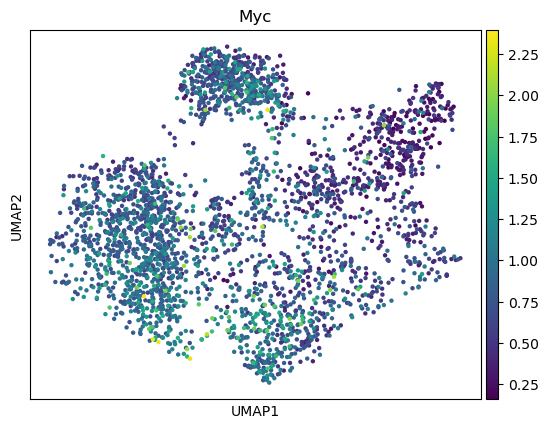

In [46]:
sc.pl.umap(
    tcell_myc_cart,
    color='Myc'
)

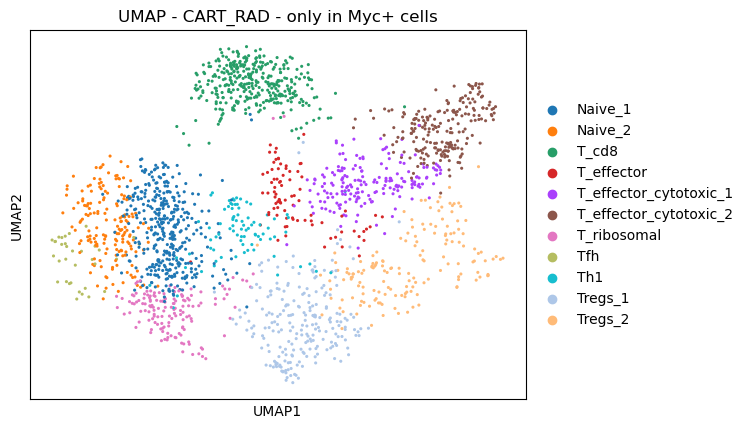

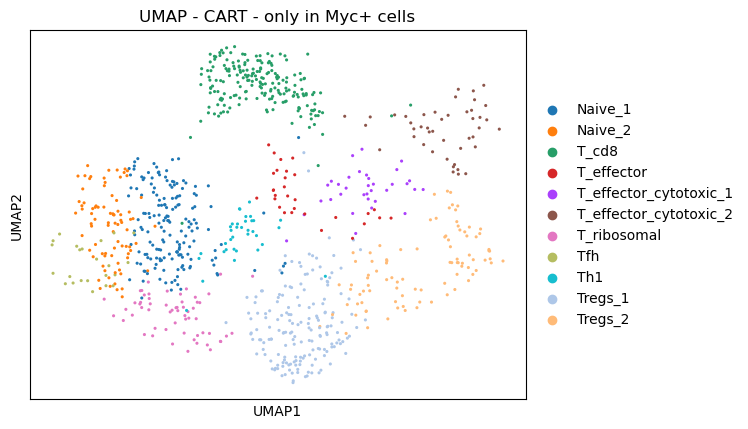

In [47]:
#two plots per conditon
for condition in tcell_myc_cart.obs['Condition'].unique():
    # Subset the data for the current sample
    subset_data = tcell_myc_cart[tcell_myc_cart.obs['Condition'] == condition, :]
    # Plot UMAP with color based on batch
    sc.pl.umap(subset_data, color='T_cell_type_fine', title=f'UMAP - {condition} - only in Myc+ cells', size=20)



TRun binomial testing to see if Myc+ fraction in our CART+RAD is significantly higher than in the only CART cells. 

In this case our reference Probabilty is the amount of Myc positive cells found in the CART only dataset. While what we want to test is that the probability of finding more Myc positive cells in CART+RAD is higher or lower.
For this we are going to use the scipy.stats.binomtest https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.binomtest.html

scipy.stats.binomtest(k, n, p=0.5, alternative='two-sided')[source]#

k=would be the number of successes in pur case number of positive CART+RAD Myc cells
n=number of total CART+RAD cells
p=ratio of Myc+/CART cells

In [48]:
from scipy.stats import binomtest
from statsmodels.stats.multitest import multipletests
import scipy.stats

In [49]:
def run_binomial(cell_type_annotation, list_of_genes):
    gene_dataframe = pd.DataFrame()

    for gene in list_of_genes:
        print(f'checking expression of {gene}')
        for condition in t_cell_data.obs["Condition"].unique():
            gene_object_table = t_cell_data[t_cell_data.obs['Condition'].isin([condition])]
            for cell_type in gene_object_table.obs[cell_type_annotation].unique():
                #subset t cells to rerun clustering and annotation.
                subset_df = gene_object_table[gene_object_table.obs[cell_type_annotation].isin([cell_type])]
                new_df=pd.DataFrame({'Expression':subset_df[:, gene].layers["counts"].todense().A1})
                new_df['Gene'] = gene
                new_df['Condition'] = condition
                new_df['Cell_type'] = cell_type
                gene_dataframe = pd.concat([gene_dataframe, new_df], ignore_index=True)
    print(gene_dataframe)
    #iterate through each cell type (cluster) to run the binomial testing
    results_df = pd.DataFrame(columns=['Cell_type', 'Gene', 'p_value'])
    for cell_types in gene_dataframe.Cell_type.unique():
        sub_gene_df = gene_dataframe[gene_dataframe['Cell_type']==cell_types]
    
        k=len(sub_gene_df[(sub_gene_df['Condition'] == 'CART_RAD') & (sub_gene_df['Expression'] > 0)])
        print(f'Number of Myc+ cells in CART_RAD in {cell_types} is:  {k}')
        
        n=len(sub_gene_df[sub_gene_df['Condition'] == 'CART_RAD'])

        print(f'Number of total cells in CART_RAD in {cell_types} is:  {n}')
        cart_alone=len(sub_gene_df[sub_gene_df['Condition'] == 'CART'])
        print(f'Number of total cells in CART alone in {cell_types} is:  {cart_alone}')
        cart_myc=len(sub_gene_df[(sub_gene_df['Condition'] == 'CART') & (sub_gene_df['Expression'] > 0)])
        print(f'Number of Myc+ cells in CART alone in {cell_types} is:  {cart_myc}')
        p=len(sub_gene_df[(sub_gene_df['Condition'] == 'CART') & (sub_gene_df['Expression'] > 0)])/len(sub_gene_df[sub_gene_df['Condition'] == 'CART'])

        print(f'Ratio of Myc+ cells in CART alone in {cell_types} is:  {p}')
        results=binomtest(k, n=n, p=p, alternative='two-sided')

        print(f'Binomial testing results for {cell_types} is : {results}')
        p_value=results.pvalue
        results_df = pd.concat([results_df, pd.DataFrame({'Cell_type': [cell_types], 'Gene': [gene], 'p_value': [p_value]})], ignore_index=True)

    return results_df

In [50]:
bin_p_res = run_binomial('T_cell_type_fine', ['Myc'])

checking expression of Myc
       Expression Gene Condition Cell_type
0             0.0  Myc  CART_RAD   Tregs_1
1             0.0  Myc  CART_RAD   Tregs_1
2             0.0  Myc  CART_RAD   Tregs_1
3             0.0  Myc  CART_RAD   Tregs_1
4             0.0  Myc  CART_RAD   Tregs_1
...           ...  ...       ...       ...
27458         0.0  Myc      CART       Tfh
27459         0.0  Myc      CART       Tfh
27460         0.0  Myc      CART       Tfh
27461         0.0  Myc      CART       Tfh
27462         0.0  Myc      CART       Tfh

[27463 rows x 4 columns]
Number of Myc+ cells in CART_RAD in Tregs_1 is:  223
Number of total cells in CART_RAD in Tregs_1 is:  2712
Number of total cells in CART alone in Tregs_1 is:  1551
Number of Myc+ cells in CART alone in Tregs_1 is:  172
Ratio of Myc+ cells in CART alone in Tregs_1 is:  0.11089619600257898
Binomial testing results for Tregs_1 is : BinomTestResult(k=223, n=2712, alternative='two-sided', statistic=0.08222713864306784, pvalue=8.265

/tmp/ipykernel_164902/2372070553.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Cell_type': [cell_types], 'Gene': [gene], 'p_value': [p_value]})], ignore_index=True)


In [51]:
bin_p_res['adjusted_p_value'] = multipletests(bin_p_res['p_value'], method='fdr_bh')[1]
bin_p_res

Cell_type Gene       p_value  adjusted_p_value
0                  Tregs_1  Myc  8.265649e-07          0.000009
1                  Tregs_2  Myc  8.394578e-01          0.964459
2              T_ribosomal  Myc  5.966079e-02          0.164067
3                  Naive_1  Myc  9.785450e-01          0.978545
4                    T_cd8  Myc  4.322312e-03          0.015848
5                      Tfh  Myc  1.913630e-01          0.420999
6   T_effector_cytotoxic_2  Myc  3.880574e-01          0.609804
7                      Th1  Myc  3.037730e-06          0.000017
8   T_effector_cytotoxic_1  Myc  8.767805e-01          0.964459
9                  Naive_2  Myc  2.978783e-01          0.546110
10              T_effector  Myc  5.123086e-01          0.704424

Compute proportions of Myc in each of the samples and run t-test for each cell type.

In [52]:
def run_ttest_myc_prop(cell_type_annotation, list_of_genes):
    prop_df = pd.DataFrame()

    for gene in list_of_genes:
        print(f'checking expression of {gene}')
        for sample in t_cell_data.obs["Sample"].unique():
            gene_object_table = t_cell_data[t_cell_data.obs['Sample'].isin([sample])]
            for cell_type in gene_object_table.obs[cell_type_annotation].unique():
                gene_dataframe =  pd.DataFrame()
                # Subset T cells to rerun clustering and annotation.
                subset_df = gene_object_table[gene_object_table.obs[cell_type_annotation].isin([cell_type])]
                condition = ', '.join(subset_df.obs['Condition'].unique().astype(str))
                new_df = pd.DataFrame({'Expression': subset_df[:, gene].layers["counts"].todense().A1})
                new_df['Sample'] = sample
                gene_dataframe = pd.concat([gene_dataframe, new_df], ignore_index=True)
                
                # Calculate proportion of MYC-positive cells
                myc_pos=(gene_dataframe['Expression'] > 0).sum() 
                #print(f'{myc_pos} number of myc pos for - {sample} and {cell_type}')
                tot_cells = len(gene_dataframe['Expression'])

                #print(f' {tot_cells} total cells - {sample} and {cell_type}')
                prop_myc=myc_pos/tot_cells
                #print(f' {prop_myc} prop of myc + cells in - {sample} and {cell_type}')
                
                # Create a row for the proportion DataFrame
                prop_df = pd.concat([prop_df, pd.DataFrame({'prop': [prop_myc], 'Sample': [sample], 'Condition': [condition], 'Cell_type': [cell_type]})], ignore_index=True)

    print(prop_df)
    for cell_type in prop_df["Cell_type"].unique():
        sub_df=prop_df[prop_df["Cell_type"]==cell_type]
        rad_cart_prop=sub_df[sub_df["Condition"]=="CART_RAD"]['prop']
        #print(f'proportions for RAD+CART in {cell_type} is {rad_cart_prop}')
        cart_prop=sub_df[sub_df["Condition"]=="CART"]['prop']
        #print(f'proportions for only CART in {cell_type} is {cart_prop}')
        t_statistic, p_value = scipy.stats.ttest_ind(rad_cart_prop, cart_prop, permutations=1000, random_state=None, alternative='two-sided')
        print(f"Cell type: {cell_type}, p-value: {p_value}")
    return(prop_df)

In [53]:
prop_myc_celltype_sample=run_ttest_myc_prop('T_cell_type_fine', ['Myc'])

checking expression of Myc
        prop        Sample Condition               Cell_type
0   0.090543  out_Mouse_11  CART_RAD                 Tregs_1
1   0.071928  out_Mouse_11  CART_RAD                 Tregs_2
2   0.097701  out_Mouse_11  CART_RAD             T_ribosomal
3   0.116838  out_Mouse_11  CART_RAD                 Naive_1
4   0.244444  out_Mouse_11  CART_RAD                   T_cd8
..       ...           ...       ...                     ...
61  0.122616   out_Mouse_8      CART                 Naive_1
62  0.090909   out_Mouse_8      CART                 Naive_2
63  0.107914   out_Mouse_8      CART  T_effector_cytotoxic_1
64  0.086486   out_Mouse_8      CART             T_ribosomal
65  0.071429   out_Mouse_8      CART                     Tfh

[66 rows x 4 columns]
Cell type: Tregs_1, p-value: 0.1
Cell type: Tregs_2, p-value: 0.9
Cell type: T_ribosomal, p-value: 0.3
Cell type: Naive_1, p-value: 1.0
Cell type: T_cd8, p-value: 0.4
Cell type: Tfh, p-value: 0.5
Cell type: T_effector_

In [54]:
#prop_myc_celltype_sample
prop_myc_celltype_sample['Condition'] = prop_myc_celltype_sample['Condition'].replace("CART", "Cy/mCART19")
prop_myc_celltype_sample['Condition'] = prop_myc_celltype_sample['Condition'].replace("CART_RAD", "Cy/LD-TBI/mCART19")
prop_myc_celltype_sample = prop_myc_celltype_sample.sort_values(by='Condition', ascending=False)

In [55]:
#save proportion data.
prop_myc_celltype_sample.to_csv('../t_cell_analysis/myc_pos_prop_t_subclusters.csv', index=False)  

In [56]:
prop_myc_celltype_sample = pd.merge(prop_myc_celltype_sample,bin_p_res)
prop_myc_celltype_sample

prop        Sample          Condition               Cell_type Gene  \
0   0.187500   out_Mouse_4         Cy/mCART19  T_effector_cytotoxic_2  Myc   
1   0.086957   out_Mouse_4         Cy/mCART19  T_effector_cytotoxic_1  Myc   
2   0.070175  out_Mouse_23         Cy/mCART19                 Tregs_2  Myc   
3   0.122642  out_Mouse_23         Cy/mCART19  T_effector_cytotoxic_1  Myc   
4   0.194444  out_Mouse_23         Cy/mCART19  T_effector_cytotoxic_2  Myc   
..       ...           ...                ...                     ...  ...   
61  0.176190  out_Mouse_13  Cy/LD-TBI/mCART19  T_effector_cytotoxic_2  Myc   
62  0.124424  out_Mouse_13  Cy/LD-TBI/mCART19                     Th1  Myc   
63  0.085271  out_Mouse_13  Cy/LD-TBI/mCART19                     Tfh  Myc   
64  0.071928  out_Mouse_11  Cy/LD-TBI/mCART19                 Tregs_2  Myc   
65  0.090543  out_Mouse_11  Cy/LD-TBI/mCART19                 Tregs_1  Myc   

         p_value  adjusted_p_value  
0   3.880574e-01          0.609804  
1   8.767805e-01          0.964459  
2   8.394578e-01          0.964459  
3   8.767805e-01          0.964459  
4   3.880574e-01          0.609804  
..           ...               ...  
61  3.880574e-01          0.609804  
62  3.037730e-06          0.000017  
63  1.913630e-01          0.420999  
64  8.394578e-01          0.964459  
65  8.265649e-07          0.000009  

[66 rows x 7 columns]

In [57]:
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Naive_1', 'Cell_type'] = 'N_1'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Naive_2', 'Cell_type'] = 'N_2'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'T_cd8', 'Cell_type'] = 'CD8'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'T_effector', 'Cell_type'] = 'EFF'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'T_effector_cytotoxic_1', 'Cell_type'] = 'eCTL_1'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'T_effector_cytotoxic_2', 'Cell_type'] = 'eCTL_2'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'T_ribosomal', 'Cell_type'] = 'Ribo'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Tfh', 'Cell_type'] = 'FH'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Th1', 'Cell_type'] = 'H'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Tregs_1', 'Cell_type'] = 'Reg_1'
prop_myc_celltype_sample.loc[prop_myc_celltype_sample['Cell_type'] == 'Tregs_2', 'Cell_type'] = 'Reg_2'

In [58]:
order_categories=['N_1', 'N_2', 'CD8', 'EFF', 'eCTL_1', 'eCTL_2', 'Ribo', 'FH', 'H','Reg_1', 'Reg_2' ]

In [59]:
prop_myc_celltype_sample['Cell_type'] = pd.Categorical(prop_myc_celltype_sample['Cell_type'], categories=order_categories, ordered=True)

prop_myc_celltype_sample = prop_myc_celltype_sample.sort_values(by=['Cell_type', 'Condition'], ascending=[True, False])
prop_myc_celltype_sample

prop        Sample          Condition Cell_type Gene   p_value  \
6   0.099315   out_Mouse_4         Cy/mCART19       N_1  Myc  0.978545   
22  0.122616   out_Mouse_8         Cy/mCART19       N_1  Myc  0.978545   
31  0.120205  out_Mouse_23         Cy/mCART19       N_1  Myc  0.978545   
46  0.116838  out_Mouse_11  Cy/LD-TBI/mCART19       N_1  Myc  0.978545   
53  0.117264   out_Mouse_5  Cy/LD-TBI/mCART19       N_1  Myc  0.978545   
..       ...           ...                ...       ...  ...       ...   
11  0.035019   out_Mouse_4         Cy/mCART19     Reg_2  Myc  0.839458   
21  0.074205   out_Mouse_8         Cy/mCART19     Reg_2  Myc  0.839458   
49  0.059429   out_Mouse_5  Cy/LD-TBI/mCART19     Reg_2  Myc  0.839458   
59  0.061224  out_Mouse_13  Cy/LD-TBI/mCART19     Reg_2  Myc  0.839458   
64  0.071928  out_Mouse_11  Cy/LD-TBI/mCART19     Reg_2  Myc  0.839458   

    adjusted_p_value  
6           0.978545  
22          0.978545  
31          0.978545  
46          0.978545  
53          0.978545  
..               ...  
11          0.964459  
21          0.964459  
49          0.964459  
59          0.964459  
64          0.964459  

[66 rows x 7 columns]

In [61]:
prop_myc_celltype_sample[["Cell_type", "adjusted_p_value"]].drop_duplicates()

Cell_type  adjusted_p_value
6        N_1          0.978545
8        N_2          0.546110
15       CD8          0.015848
10       EFF          0.704424
1     eCTL_1          0.964459
0     eCTL_2          0.609804
9       Ribo          0.164067
5         FH          0.420999
12         H          0.000017
7      Reg_1          0.000009
2      Reg_2          0.964459

In [62]:
final_parameters = prop_myc_celltype_sample[["Cell_type", "adjusted_p_value"]].drop_duplicates()
final_parameters_list = final_parameters['adjusted_p_value'].tolist()

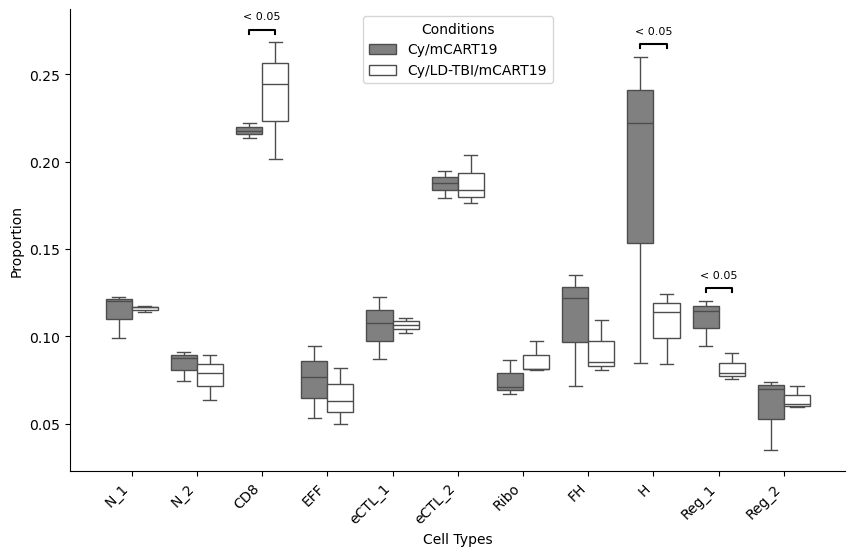

In [63]:
threshold = 0.05

plt.figure(figsize=(10, 6))

# Create the box plot
ax = sns.boxplot(
    x="Cell_type", 
    y="prop", 
    hue="Condition", 
    data=prop_myc_celltype_sample, 
    palette=["gray", "white"], 
    linewidth=1,
)

# Get x-axis positions for each category
category_positions = {
    text.get_text(): pos for pos, text in enumerate(ax.get_xticklabels())
}

# Annotate significance
for i, param in enumerate(final_parameters_list):
    # Get the current cell type name
    cell_type = prop_myc_celltype_sample['Cell_type'].cat.categories[i]  # Match plot order

    # Only annotate if the parameter meets the condition
    if param < threshold:
        # Find the x-axis position for this cell type
        if cell_type in category_positions:
            x_pos = category_positions[cell_type]
            
            # Get max y-value for the cell type
            max_y = prop_myc_celltype_sample[prop_myc_celltype_sample["Cell_type"] == cell_type]["prop"].max()
            y = max_y + 0.005  # Add margin above the max value
            h = 0.002  # Height of the annotation line

            # Determine x-positions for the two conditions
            x1 = x_pos - 0.2  # Adjust for Condition 1
            x2 = x_pos + 0.2  # Adjust for Condition 2

            # Draw the significance annotation
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")
            ax.text((x1 + x2) / 2, y + h + 0.005, "< 0.05", 
                    ha="center", va="bottom", color="black", fontsize=8)

# Adjust legend position
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((0.5, 1))
    legend.set_loc("center")

# Add labels and legend
ax.set_ylabel("Proportion")
ax.set_xlabel("Cell Types")
ax.legend(title="Conditions", loc="upper center")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis labels
plt.xticks(rotation=45, ha="right")  # Rotate by 45 degrees, align to the right for readability

# Save or display the plot
#plt.savefig("myc_pos_proportion_binomial_analysis_public.pdf", format="pdf", bbox_inches="tight")
plt.show()

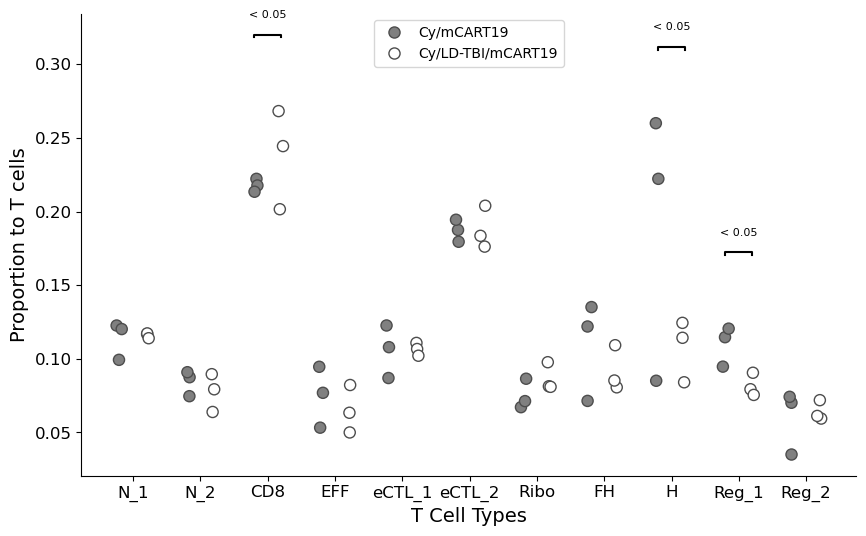

In [71]:
threshold = 0.05
plt.figure(figsize=(10, 6))
ax = sns.stripplot(
    x="Cell_type", 
    y="prop", 
    hue="Condition", 
    data=prop_myc_celltype_sample, 
    palette=["gray", "white"],
    #palette=["#BF3EFF", "#FFA500"], 
    linewidth=1, 
    dodge=True,  # Separate dots by condition
    jitter=True,  # Add jitter to avoid overlap
    size=8
)

# Get x-axis positions for each category
category_positions = {
    text.get_text(): pos for pos, text in enumerate(ax.get_xticklabels())
}

# Annotate significance
for i, param in enumerate(final_parameters_list):
    # Get the current cell type name
    cell_type = prop_myc_celltype_sample['Cell_type'].cat.categories[i]  # Match plot order

     # Find the x-axis position for this cell type
    if cell_type in category_positions:
        x_pos = category_positions[cell_type]
        
        # Get max y-value for the cell type
        max_y = prop_myc_celltype_sample[prop_myc_celltype_sample["Cell_type"] == cell_type]["prop"].max()
        y = max_y + 0.05  # Add margin above the max value
        h = 0.002  # Height of the annotation line

        # Determine x-positions for the two conditions
        x1 = x_pos - 0.2  # Adjust for Condition 1
        x2 = x_pos + 0.2  # Adjust for Condition 2

        if param < threshold:
            # Draw the significance annotation
            ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="black")
            # Format `param` in scientific notation
            #param_text = f"{param:.2e}"
            ax.text((x1 + x2) / 2, y + h + 0.01, "< 0.05", 
                    ha="center", va="bottom", color="black", fontsize=8)
        #else:
            # Handle non-significant cases (optional visual adjustment)
            #ax.plot([x1, x1, x2, x2], [y, y + h, y + h, y], lw=1.5, color="gray")
            #ax.text((x1 + x2) / 2, y + h + 0.01, "Not-sig", 
                    #ha="center", va="bottom", color="gray", fontsize=8, style="italic")

# Adjust legend position
legend = ax.get_legend()
if legend:
    legend.set_bbox_to_anchor((0.5, 1))
    legend.set_loc("center")

# Add labels and legend
ax.set_ylabel("Proportion to T cells", fontsize=14)
ax.set_xlabel("T Cell Types", fontsize=14)
ax.legend(title="", loc="upper center")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Rotate x-axis labels
#plt.xticks(rotation=45, ha="right")  # Rotate by 45 degrees, align to the right for readability
ax.tick_params(axis='x', labelsize=12)  # Increase x-axis tick labels
ax.tick_params(axis='y', labelsize=12)  # Increase y-axis tick labels


# Save or display the plot
plt.savefig("dot_plot_option2_myc_pos_proportion_binomial_analysis_public.pdf", format="pdf", bbox_inches="tight")
plt.show()

We will run again the binomial analysis but with the generic T cell types.

In [53]:
bin_p_res_generic = run_binomial('Cell_type_generic', ['Myc'])
bin_p_res_generic['adjusted_p_value'] = multipletests(bin_p_res_generic['p_value'], method='fdr_bh')[1]
bin_p_res_generic

checking expression of Myc
       Expression Gene Condition Cell_type
0             0.0  Myc  CART_RAD      Treg
1             0.0  Myc  CART_RAD      Treg
2             0.0  Myc  CART_RAD      Treg
3             0.0  Myc  CART_RAD      Treg
4             0.0  Myc  CART_RAD      Treg
...           ...  ...       ...       ...
27458         0.0  Myc      CART      Treg
27459         0.0  Myc      CART      Treg
27460         1.0  Myc      CART      Treg
27461         0.0  Myc      CART      Treg
27462         0.0  Myc      CART      Treg

[27463 rows x 4 columns]
Number of Myc+ cells in CART_RAD in Treg is:  388
Number of total cells in CART_RAD in Treg is:  5267
Number of total cells in CART alone in Treg is:  2992
Number of Myc+ cells in CART alone in Treg is:  264
Ratio of Myc+ cells in CART alone in Treg is:  0.08823529411764706
Binomial testing results for Treg is : BinomTestResult(k=388, n=5267, alternative='two-sided', statistic=0.07366622365673059, pvalue=0.00014969857162658735)

/tmp/ipykernel_1263567/2372070553.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Cell_type': [cell_types], 'Gene': [gene], 'p_value': [p_value]})], ignore_index=True)


Cell_type Gene   p_value  adjusted_p_value
0      Treg  Myc  0.000150          0.000299
1   T_cells  Myc  0.195668          0.195668

In [18]:
prop_myc_celltype_sample_generic=run_ttest_myc_prop('Cell_type_generic', ['Myc'])

checking expression of Myc
        prop        Sample Condition Cell_type
0   0.077865  out_Mouse_11  CART_RAD      Treg
1   0.128037  out_Mouse_11  CART_RAD   T_cells
2   0.122587  out_Mouse_13  CART_RAD   T_cells
3   0.069911  out_Mouse_13  CART_RAD      Treg
4   0.119398  out_Mouse_23      CART   T_cells
5   0.083738  out_Mouse_23      CART      Treg
6   0.118371   out_Mouse_4      CART   T_cells
7   0.067227   out_Mouse_4      CART      Treg
8   0.107779   out_Mouse_5  CART_RAD   T_cells
9   0.071914   out_Mouse_5  CART_RAD      Treg
10  0.096336   out_Mouse_8      CART      Treg
11  0.136187   out_Mouse_8      CART   T_cells
Cell type: Treg, p-value: 0.4
Cell type: T_cells, p-value: 0.6


In [19]:
#save proportion data.
prop_myc_celltype_sample_generic.to_csv('../t_cell_analysis/myc_pos_prop_t_generic.csv', index=False)  

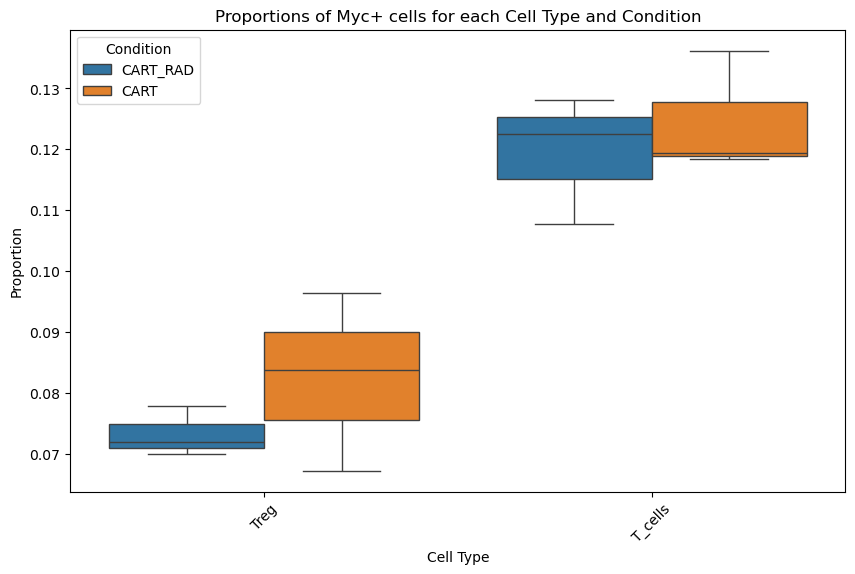

In [20]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cell_type', y='prop', hue='Condition', data=prop_myc_celltype_sample_generic)
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.title('Proportions of Myc+ cells for each Cell Type and Condition')
plt.legend(title='Condition')
plt.xticks(rotation=45) 
plt.show()


Run it for T cells in general between conditions. 


In [21]:
t_cell_data.obs["Generic_T_cells"] = "T_cells"

In [23]:
bin_p_res_generic_tcells = run_binomial('Generic_T_cells', ['Myc'])
bin_p_res_generic_tcells['adjusted_p_value'] = multipletests(bin_p_res_generic_tcells['p_value'], method='fdr_bh')[1]
bin_p_res_generic_tcells

checking expression of Myc
       Expression Gene Condition Cell_type
0             0.0  Myc  CART_RAD   T_cells
1             0.0  Myc  CART_RAD   T_cells
2             0.0  Myc  CART_RAD   T_cells
3             0.0  Myc  CART_RAD   T_cells
4             0.0  Myc  CART_RAD   T_cells
...           ...  ...       ...       ...
27458         1.0  Myc      CART   T_cells
27459         0.0  Myc      CART   T_cells
27460         1.0  Myc      CART   T_cells
27461         0.0  Myc      CART   T_cells
27462         0.0  Myc      CART   T_cells

[27463 rows x 4 columns]
Number of Myc+ cells in CART_RAD in T_cells is:  2042
Number of total cells in CART_RAD in T_cells is:  19017
Number of total cells in CART alone in T_cells is:  8446
Number of Myc+ cells in CART alone in T_cells is:  940
Ratio of Myc+ cells in CART alone in T_cells is:  0.11129528771015866
Binomial testing results for T_cells is : BinomTestResult(k=2042, n=19017, alternative='two-sided', statistic=0.10737760950728295, pvalue=0

/tmp/ipykernel_2507913/2372070553.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, pd.DataFrame({'Cell_type': [cell_types], 'Gene': [gene], 'p_value': [p_value]})], ignore_index=True)


Cell_type Gene   p_value  adjusted_p_value
0   T_cells  Myc  0.087946          0.087946

In [24]:
prop_myc_celltype_sample_generic=run_ttest_myc_prop('Generic_T_cells', ['Myc'])

checking expression of Myc
       prop        Sample Condition Cell_type
0  0.114177  out_Mouse_11  CART_RAD   T_cells
1  0.109239  out_Mouse_13  CART_RAD   T_cells
2  0.111413  out_Mouse_23      CART   T_cells
3  0.102480   out_Mouse_4      CART   T_cells
4  0.096983   out_Mouse_5  CART_RAD   T_cells
5  0.115337   out_Mouse_8      CART   T_cells
Cell type: T_cells, p-value: 0.6


In [25]:
#save proportion data.
prop_myc_celltype_sample_generic.to_csv('../t_cell_analysis/myc_pos_prop_t_generic_all.csv', index=False)  

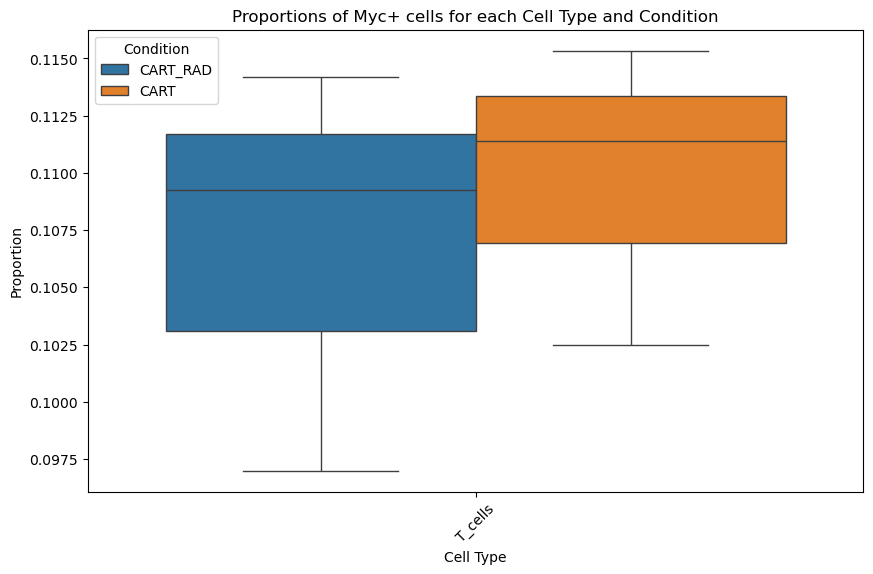

In [26]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cell_type', y='prop', hue='Condition', data=prop_myc_celltype_sample_generic)
plt.xlabel('Cell Type')
plt.ylabel('Proportion')
plt.title('Proportions of Myc+ cells for each Cell Type and Condition')
plt.legend(title='Condition')
plt.xticks(rotation=45) 
plt.show()

Check if markers are enriched in any of the conditions.

Score a set of genes [Satija15].
The score is the average expression of a set of genes subtracted with the average expression of a reference set of genes. The reference set is randomly sampled from the gene_pool for each binned expression value.

In [37]:
#run gene score enrichment of the gene lists michelle shared for the differnet cell types and conditions
custom_pathways= pd.read_csv('../t_cell_analysis/pseudobulk_DE/custom_pathways_MF.csv')


In [38]:
#marker_list = []
for pathway in custom_pathways.geneset.unique():
    values = custom_pathways[custom_pathways.geneset==pathway]
    values = values['genesymbol'].tolist()
    print(f'length of the patwhay list {pathway} is {len(pathway)}')
    #cleaned_values = [value for value in values if not pd.isna(value)]
    sc.tl.score_genes(t_cell_data, values, ctrl_size=10, gene_pool=None, n_bins=10, score_name='score_'+pathway, random_state=0, copy=False, use_raw=None)


length of the patwhay list Exhaustion_Persistance_MF is 25
computing score 'score_Exhaustion_Persistance_MF'
    finished (0:00:00)
length of the patwhay list Activation_MF is 13
computing score 'score_Activation_MF'
    finished (0:00:00)
length of the patwhay list Death_receptors_MF is 18
computing score 'score_Death_receptors_MF'
    finished (0:00:00)


In [39]:
# i want to create a split violin plot to show the scores of the enrichment. So first i need to create a table with those scores and then unse seaborn package.
score_pathway_dataframe = pd.DataFrame()
for column_score in t_cell_data.obs.columns:
    if column_score.startswith("score_"):
        print(f'{column_score}')
        subset_df = t_cell_data.obs[['Condition', 'T_cell_type_fine',column_score]]
        #rename score column name to value and add a new column named score_name
        subset_df.rename(columns={column_score: 'Value'}, inplace=True)
        subset_df['score_name']=column_score
        score_pathway_dataframe = pd.concat([score_pathway_dataframe, subset_df], ignore_index=True)
    
print(score_pathway_dataframe)


score_Exhaustion_Persistance_MF
score_Activation_MF
score_Death_receptors_MF
      Condition T_cell_type_fine     Value                       score_name
0      CART_RAD          Tregs_1  0.283211  score_Exhaustion_Persistance_MF
1      CART_RAD          Tregs_2  0.227374  score_Exhaustion_Persistance_MF
2      CART_RAD      T_ribosomal -0.136716  score_Exhaustion_Persistance_MF
3      CART_RAD          Naive_1  0.044181  score_Exhaustion_Persistance_MF
4      CART_RAD          Naive_1  0.144719  score_Exhaustion_Persistance_MF
...         ...              ...       ...                              ...
82384      CART          Tregs_1 -0.003180         score_Death_receptors_MF
82385      CART      T_ribosomal -0.077949         score_Death_receptors_MF
82386      CART          Naive_1 -0.166326         score_Death_receptors_MF
82387      CART          Tregs_2 -0.216231         score_Death_receptors_MF
82388      CART          Tregs_2 -0.050614         score_Death_receptors_MF

[82389 row

/tmp/ipykernel_1572953/111335620.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={column_score: 'Value'}, inplace=True)
/tmp/ipykernel_1572953/111335620.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df['score_name']=column_score
/tmp/ipykernel_1572953/111335620.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset_df.rename(columns={

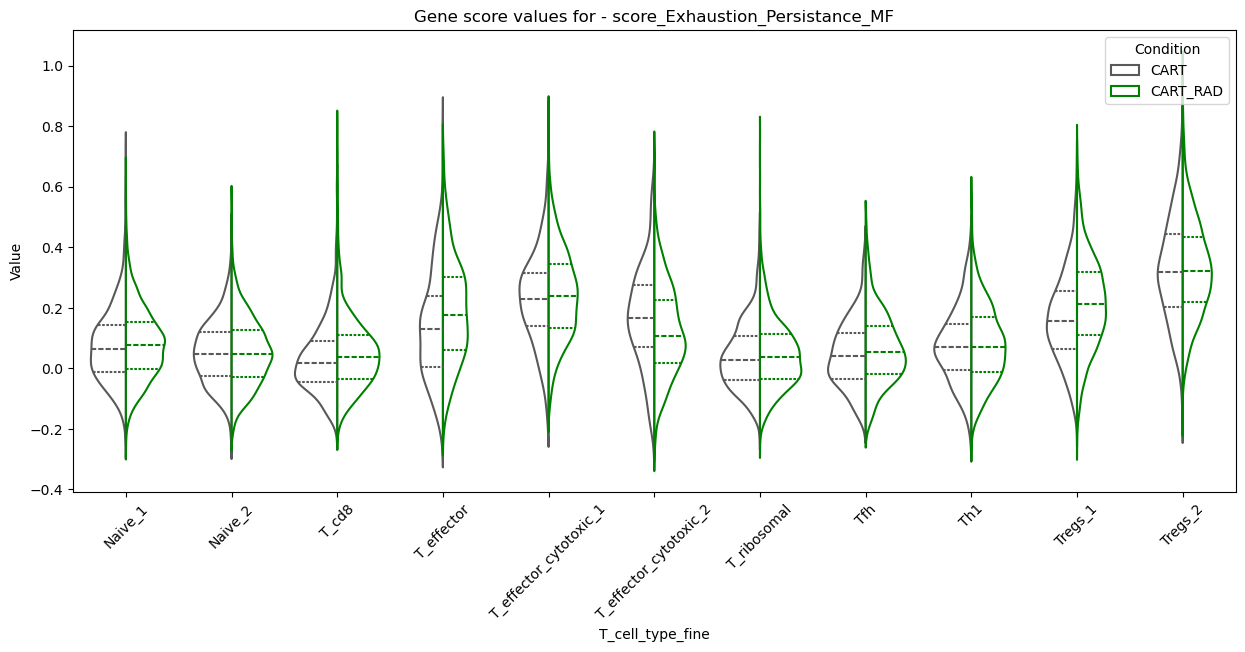

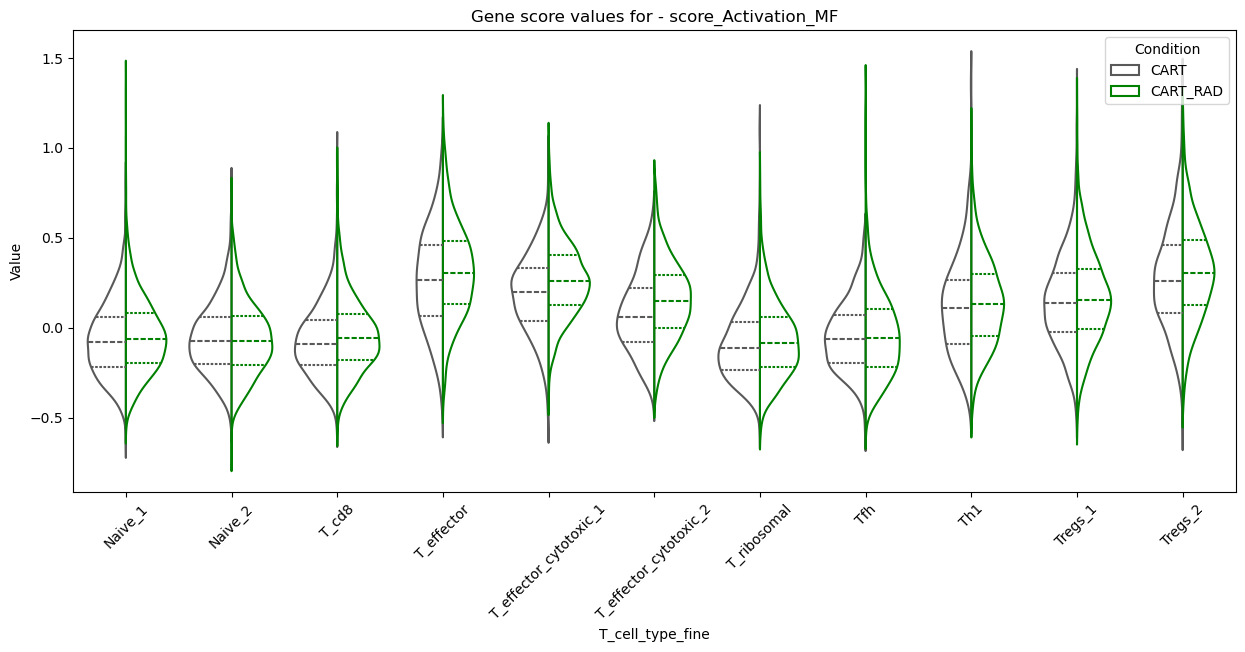

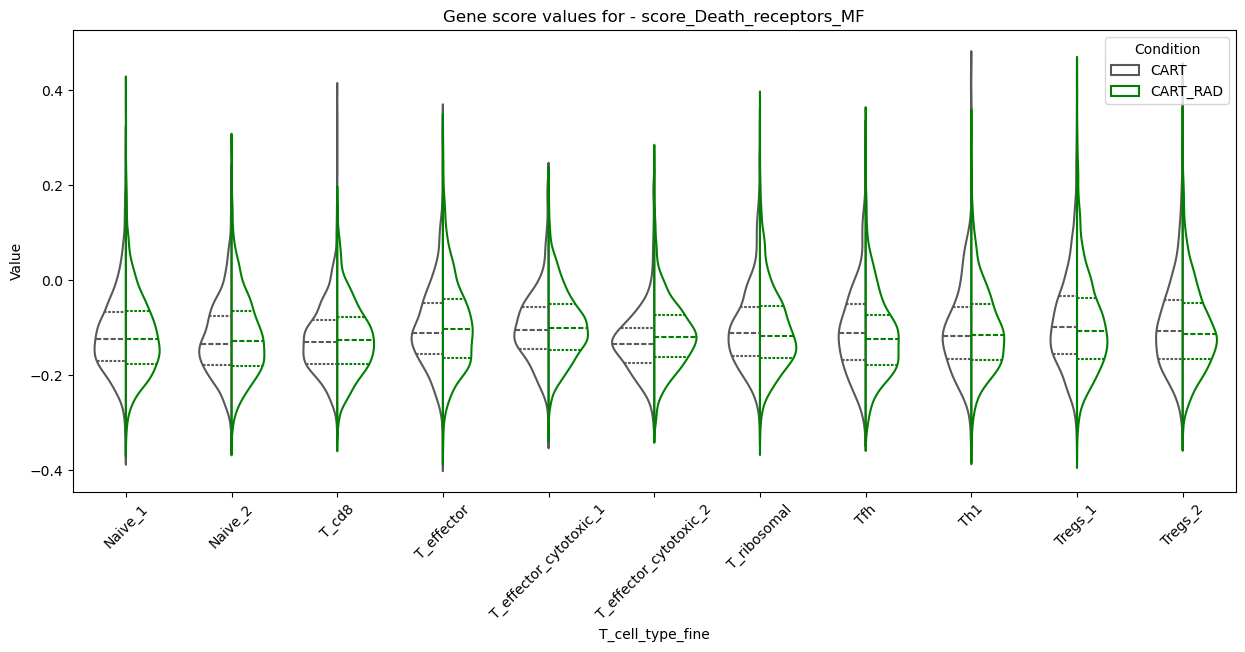

In [40]:
for pathway in score_pathway_dataframe.score_name.unique():
    # Subset the data for the current sample
    subset_data = score_pathway_dataframe[score_pathway_dataframe['score_name'] == pathway]
    # Plot UMAP with color based on batch
    #print(subset_data)
    plt.figure(figsize=(15, 6))

    sns.violinplot(data=subset_data, x="T_cell_type_fine", y="Value", hue="Condition",
               split=True, inner="quart",fill=False,
               palette={"CART_RAD": "g", "CART": ".35"}, dodge="auto") #gap=2)
    # Rotate x-axis labels
    plt.xticks(rotation=45)
    plt.title(f'Gene score values for - {pathway}')
    # Show the plot
    plt.show()